**Names of all group members:**

Lucas Gimeno

Matteo Bodmer

Nils Johnson

Haiyen Van

Jonas Isler

---

All code below is only suggestive and you may as well use different approaches.

In [1]:
# Exercise 1.
import numpy as np
np.random.seed(0)  # for reproducibility

# Given parameters
m = 20000   # training samples
n = 10000   # test samples
dim = 3     # number of features

# simulate explanatory variables x (the age and monthly income are assumed here to follow a continous uniform distribution)
# xi1 = age in [18, 80]
# xi2 = monthly income in [1, 15] (in CHF 1000)
# xi3 = salaried/self-employed {0,1}, with P(1)=0.1

x_age = np.random.uniform(18, 80, m + n)
x_income = np.random.uniform(1, 15, m + n)
x_employment = np.random.choice([0, 1], size=m + n, p=[0.9, 0.1])

# Combine all features into a single (m+n)x3 matrix
X = np.column_stack([x_age, x_income, x_employment])

# a) calculate empirical means and standard deviations over training data
X_train = X[:m]
X_test = X[m:]

means = X_train.mean(axis=0)
stds = X_train.std(axis=0)

print("Empirical means:")
print(f"  Age (years):           {means[0]:.2f}")
print(f"  Monthly income (kCHF): {means[1]:.2f}")
print(f"  Employment status:     {means[2]:.2f}")

print("\nEmpirical standard deviations:")
print(f"  Age (years):           {stds[0]:.2f}")
print(f"  Monthly income (kCHF): {stds[1]:.2f}")
print(f"  Employment status:     {stds[2]:.2f}")

# good, that aligns well with the expectation

# b) Can you come up with a few (2 or 3) additional features that may be relevant?
# (you don't have to implement those of course, just write down your answer in text)

#- credit history & payment behavior (how reliably someone has paid past loans, bills, contracts, etc.)
#- existing debts, loans & credit usage
#- stability (frequent address changes or job changes might be scored negatively)

Empirical means:
  Age (years):           48.74
  Monthly income (kCHF): 7.99
  Employment status:     0.10

Empirical standard deviations:
  Age (years):           18.01
  Monthly income (kCHF): 4.03
  Employment status:     0.30


In [2]:
# Exercise 2.
# Building the datasets:

sigmoid = lambda x: 1. / (1. + np.exp(-x))

# build the first dataset
def p1(x):
    return sigmoid(13.3-0.33*x[:,0]+3.5*x[:,1]-3*x[:,2])

xi1 = np.random.uniform(0, 1, m + n)   # independent uniform(0,1) variables
p1_vals = p1(X)
y1 = (xi1 <= p1_vals).astype(int)

# build the second dataset
def p2(x):
    age, income, emp = x[:,0], x[:,1], x[:,2]
    indicator_1 = (age < 25).astype(float)
    indicator_2 = (age > 75).astype(float)
    z = 5-10*indicator_1+10*indicator_2+1.1*income-emp
    return sigmoid(z)

xi2 = np.random.uniform(0, 1, m+n)
p2_vals = p2(X)
y2 = (xi2 <= p2_vals).astype(int)

# Split into training and test sets
Y1_train, Y1_test = y1[:m], y1[m:]
Y2_train, Y2_test = y2[:m], y2[m:]

In [3]:
# Exercise 2. a)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

def fit_logistic(X_train, y_train, X_test, y_test):

    # "model = LogisticRegression().fit(X_data, Y_data)" fits a model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # "pred_X = model.predict_proba(X)" evaluates the model
    # (note that it outputs both P(Y=0|X) and P(Y=1|X))
    # [:,1] means P(Y=1|X)
    p_train = model.predict_proba(X_train)[:,1]
    p_test = model.predict_proba(X_test)[:,1]
    
    # "log_loss(Y, pred_X)" evaluates the negative conditional log likelihood 
    # (also called cross-entropy loss)
    loss_train = log_loss(y_train, p_train)
    loss_test = log_loss(y_test, p_test)
    
    return model, loss_train, loss_test

# Fit the models on both datasets
log1, loss1_train, loss1_test = fit_logistic(X_train, Y1_train, X_test, Y1_test)
log2, loss2_train, loss2_test = fit_logistic(X_train, Y2_train, X_test, Y2_test)

# Calculate cross-entropy loss on both datasets for train and test
print("Dataset 1: train loss = %.4f, test loss = %.4f" % (loss1_train, loss1_test))
print("Dataset 2: train loss = %.4f, test loss = %.4f" % (loss2_train, loss2_test))



Dataset 1: train loss = 0.0297, test loss = 0.0349
Dataset 2: train loss = 0.0387, test loss = 0.0332


In [4]:
# Exercise 2. b)
# Calculate normalized data
sigma_hat = X_train.std(axis=0)
X_train_norm = X_train / sigma_hat
X_test_norm = X_test / sigma_hat

In [5]:
# Exercise 2.b) (i) and (ii)
from sklearn.svm import SVC

# "model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)" creates
# a model with kernel exp(-GAMMA \|x-x'\|_2^2) and regul. parameter C (note the relation between C and the parameter lambda from the lecture).
# "probability=True" enables the option "model.predict_proba(X)" to predict probabilities from the regression function \hat{f}^{svm}.
# "model.fit(X, Y)" optimizes the model parameters (using hinge loss)
GAMMA = 1/10
lambda_reg = 5 / (2*m)
C = 1 / (2 * lambda_reg*m)  # given formula => C = 0.2

def fit_svm(X_train, y_train, X_test, y_test):
    model = SVC(kernel='rbf', gamma=GAMMA, C=C, probability=True)
    model.fit(X_train, y_train)
    
    # Probabilities after Platt scaling
    p_train = model.predict_proba(X_train)[:,1]
    p_test = model.predict_proba(X_test)[:,1]
    
    loss_train = log_loss(y_train, p_train)
    loss_test = log_loss(y_test, p_test)
    
    return model, loss_train, loss_test

# Fit the models for both datasets (this can take up to 60 seconds with SVC)
svm1, svm1_train_loss, svm1_test_loss = fit_svm(X_train_norm, Y1_train, X_test_norm, Y1_test)
svm2, svm2_train_loss, svm2_test_loss = fit_svm(X_train_norm, Y2_train, X_test_norm, Y2_test)


In [6]:
# Exercise 2.b (iii)
# "model.predict_proba(X)" predicts probabilities from features (note that it outputs both P(Y=0|X) and P(Y=1|X))
# Calculate cross-entropy loss on both normalized datasets for train and test
print("Dataset 1: train loss = %.4f, test loss = %.4f" % (svm1_train_loss, svm1_test_loss))
print("Dataset 2: train loss = %.4f, test loss = %.4f" % (svm2_train_loss, svm2_test_loss))

Dataset 1: train loss = 0.0319, test loss = 0.0388
Dataset 2: train loss = 0.0401, test loss = 0.0343


In [7]:
# Exercise 2.b (iv)
#Would the results change using standardized data instead of normalized data? 
# No need to run any code here, only explain your reasoning.

# I don't think so.
# The rbf kernel depends on pairwise distances between points. 
# If we standardize the data (subtract the mean and divide by std), 
# we only shift all points by a constant mean vector compared to simple normalization (dividing by std). 
# Since distances between points don't change by shifting, the results should be the same.

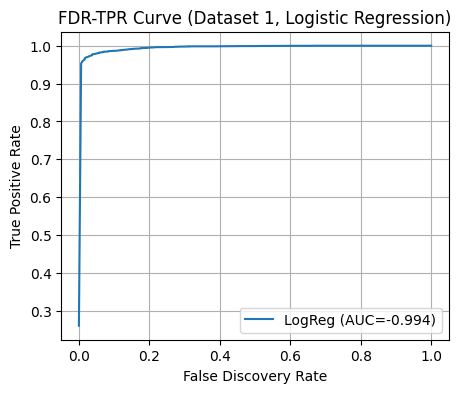

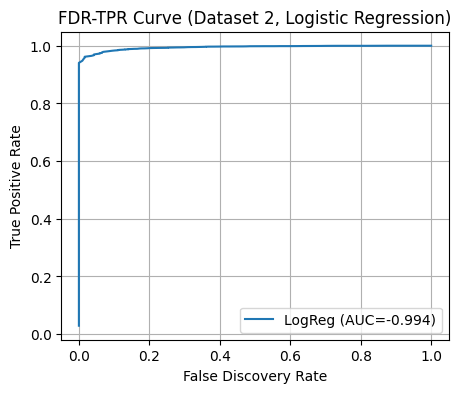

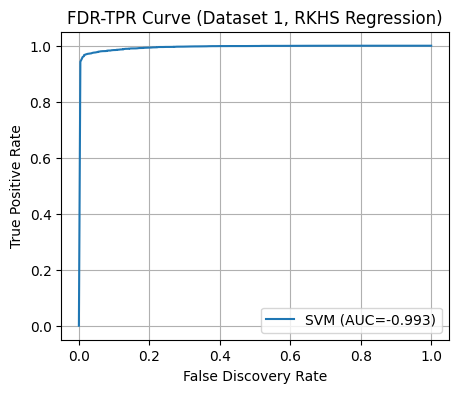

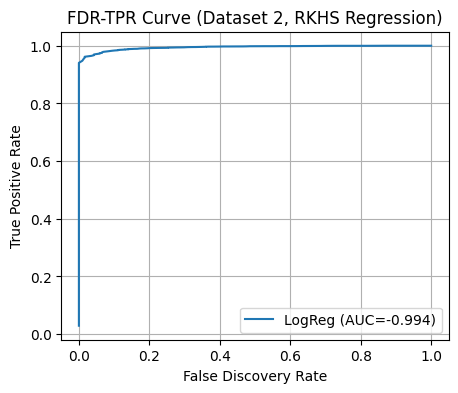

In [8]:
# Exercise 2.c
import matplotlib.pyplot as plt
# To calculate the curves, it is fine to take 100 threshold values c, i.e.,
ths = np.linspace(0, 1, 100)

def fdr_tpr_auc(y_true, p_pred, thresholds):
    FDR, TPR = [], []
    # Calculate positives (only depending on the dataset)
    positives = (y_true == 1).sum() 
    negatives = (y_true == 0).sum()

    for t in thresholds:
        pred_pos = (p_pred >= t)
        
        # Calculate true positives for all threshold values
        tp = np.logical_and(pred_pos, y_true == 1).sum()
        # Calculate false positives for all threshold values
        fp = np.logical_and(pred_pos, y_true == 0).sum()
        
        # Calculate FDR and TPR rate (points on the FDR/TPR curve) and the AUC
        TPR.append(tp / positives if positives > 0 else 0)
        FDR.append(fp / negatives if negatives > 0 else 0)

    # To approximately calculate the AUC, it is fine to simply use Riemann sums.
    # This means, if you have 100 (a_i, b_i) pairs for the curves, a_1 <= a_2 <= ...
    # then you may simply use the sum
    # sum_{i=1}^99 (b_i + b_{i+1})/2 * (a_{i+1}-a_i)
    # as the approximation of the integral (or AUC)
    auc = np.sum(
        [(TPR[i] + TPR[i+1]) / 2 * (FDR[i+1] - FDR[i])
         for i in range(len(thresholds)-1)]
    )
    return np.array(FDR), np.array(TPR), auc


# first data set & logistic regression:
# (the code should be reusable for all cases, only exchanging datasets and predicted probabilities depending on the model)
p_test_log1 = log1.predict_proba(X_test)[:,1]
FDR_log1, TPR_log1, AUC_log1 = fdr_tpr_auc(Y1_test, p_test_log1, ths)

plt.figure(figsize=(5,4))
plt.plot(FDR_log1, TPR_log1, label=f'LogReg (AUC={AUC_log1:.3f})')
plt.xlabel('False Discovery Rate')
plt.ylabel('True Positive Rate')
plt.title('FDR-TPR Curve (Dataset 1, Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()

# second data set & logistic regression:
p_test_log2 = log2.predict_proba(X_test)[:,1]
FDR_log2, TPR_log2, AUC_log2 = fdr_tpr_auc(Y2_test, p_test_log2, ths)

plt.figure(figsize=(5,4))
plt.plot(FDR_log2, TPR_log2, label=f'LogReg (AUC={AUC_log2:.3f})')
plt.xlabel('False Discovery Rate')
plt.ylabel('True Positive Rate')
plt.title('FDR-TPR Curve (Dataset 2, Logistic Regression)')
plt.legend()
plt.grid(True)
plt.show()

# first data set and rkhs regression:
p_test_svm1 = svm1.predict_proba(X_test_norm)[:, 1]
FDR_svm1, TPR_svm1, AUC_svm1 = fdr_tpr_auc(Y1_test, p_test_svm1, ths)

plt.figure(figsize=(5,4))
plt.plot(FDR_svm1, TPR_svm1, label=f'SVM (AUC={AUC_svm1:.3f})')
plt.xlabel('False Discovery Rate')
plt.ylabel('True Positive Rate')
plt.title('FDR-TPR Curve (Dataset 1, RKHS Regression)')
plt.legend()
plt.grid(True)
plt.show()

# second data set and rkhs regression:
p_test_log2 = log2.predict_proba(X_test)[:, 1]
FDR_log2, TPR_log2, AUC_log2 = fdr_tpr_auc(Y2_test, p_test_log2, ths)

plt.figure(figsize=(5,4))
plt.plot(FDR_log2, TPR_log2, label=f'LogReg (AUC={AUC_log2:.3f})')
plt.xlabel('False Discovery Rate')
plt.ylabel('True Positive Rate')
plt.title('FDR-TPR Curve (Dataset 2, RKHS Regression)')
plt.legend()
plt.grid(True)
plt.show()


Strategy (i): number of loans = 10000 (all)


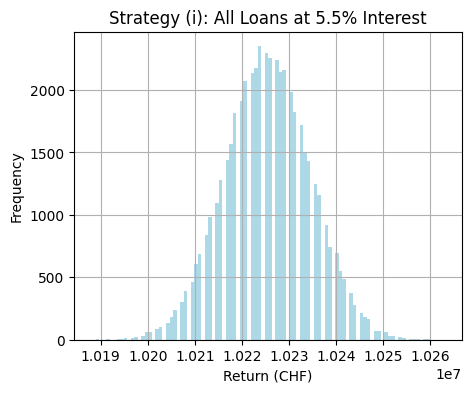

Strategy (i) mean return = 10225459.02 CHF, mean loss = -225459.02 CHF, mean profit = 225459.02 CHF, 95%-VaR = 210290.00 CHF
Strategy (ii): number of loans = 9292 (logistic ≥ 0.95)


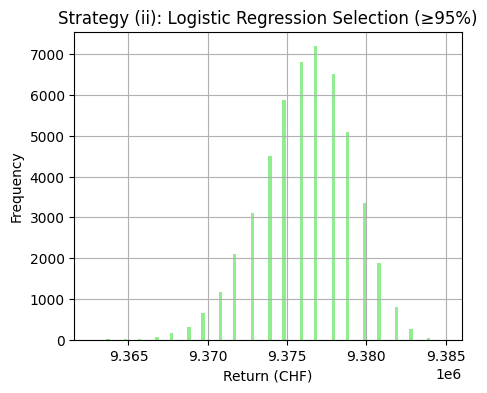

Strategy (ii) mean return = 9376201.03 CHF, mean loss = -84201.03 CHF, mean profit = 84201.03 CHF, 95%-VaR = 79790.00 CHF
Strategy (iii): number of loans = 9328 (SVM ≥ 0.95)


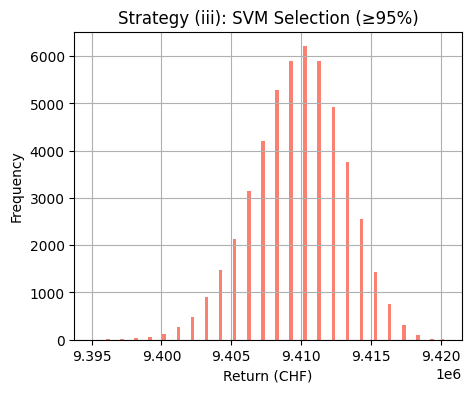

Strategy (iii) mean return = 9409679.12 CHF, mean loss = -81679.12 CHF, mean profit = 81679.12 CHF, 95%-VaR = 76110.00 CHF

Summary of Strategies:
Strategy (i)  All loans:      mean return = 10225459.02 CHF, mean loss = -225459.02 CHF,  mean profit = 225459.02 CHF, 95%-VaR = 210290.00 CHF
Strategy (ii) LogReg select:  mean return = 9376201.03 CHF, mean loss = -84201.03 CHF,  mean profit = 84201.03 CHF, 95%-VaR = 79790.00 CHF
Strategy (iii) SVM select:    mean return = 9409679.12 CHF, mean loss = -81679.12 CHF,  mean profit = 81679.12 CHF, 95%-VaR = 76110.00 CHF


In [ ]:
# Exercise 3.

# Set model parameters and define matrix D
n = X_test.shape[0]             # number of test loans
K = 50000                       # number of simulated market scenarios
loan_amount = 1000              # CHF per loan
r_all = 0.055                   # 5.5% interest rate for strategy (i)
r_sel = 0.01                    # 1% interest rate for strategies (ii) and (iii)

p2_test = p2(X_test)  

# Generate repayment matrix D ∈ {0,1}^{n×50000}
# Each column k represents one simulated market scenario
# D[i, k] = 1 if loan i is repaid (with interest), 0 if defaulted.
xi = np.random.rand(n, K)
D = (xi <= p2_test[:, None]).astype(int)

# Scenario 1:
# Define Portfolio and possible outcomes for this portfolio using matrix D
returns_1 = D*(1+r_all)*loan_amount             # return per loan if repaid
portfolio_1 = returns_1.sum(axis=0)             # total return per scenario
total_investment_1 = n*loan_amount
losses_1 = total_investment_1-portfolio_1
profit_1 = portfolio_1-total_investment_1

print(f"Strategy (i): number of loans = {n} (all)")

# Plot histogram of returns and losses
plt.figure(figsize=(5,4))
plt.hist(portfolio_1, bins=100, color='lightblue')
plt.title("Strategy (i): All Loans at 5.5% Interest")
plt.xlabel("Return (CHF)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Calculate expected return and 95%-VaR
mean_return_1 = np.mean(portfolio_1)
mean_loss_1 = np.mean(losses_1)
mean_profit_1 = np.mean(profit_1)
var95_1 = np.quantile(profit_1, 0.05)  
print(f"Strategy (i) mean return = {mean_return_1:.2f} CHF, mean loss = {mean_loss_1:.2f} CHF, mean profit = {mean_profit_1:.2f} CHF, 95%-VaR = {var95_1:.2f} CHF")


# Scenario 2:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the logistic regression model
p_pred_log2 = log2.predict_proba(X_test)[:,1]
mask_log = (p_pred_log2 >= 0.95)                # select loans with ≥95% predicted repayment prob

print(f"Strategy (ii): number of loans = {mask_log.sum()} (logistic ≥ 0.95)")

returns_2 = D[mask_log,:]*(1+r_sel)*loan_amount
portfolio_2 = returns_2.sum(axis=0)
total_investment_2 = mask_log.sum() * loan_amount
losses_2 = total_investment_2 - portfolio_2
profit_2 = portfolio_2 - total_investment_2

plt.figure(figsize=(5,4))
plt.hist(portfolio_2, bins=100, color='lightgreen')
plt.title("Strategy (ii): Logistic Regression Selection (≥95%)")
plt.xlabel("Return (CHF)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

mean_return_2 = np.mean(portfolio_2)
mean_loss_2 = np.mean(losses_2)
mean_profit_2 = np.mean(profit_2)
var95_2 = np.quantile(profit_2, 0.05)
print(f"Strategy (ii) mean return = {mean_return_2:.2f} CHF, mean loss = {mean_loss_2:.2f} CHF, mean profit = {mean_profit_2:.2f} CHF, 95%-VaR = {var95_2:.2f} CHF")

# Scenario 3:
# Define Portfolio and possible outcomes using the matrix D and the predicted default probabilities from the rkhs model
p_pred_svm2 = svm2.predict_proba(X_test_norm)[:,1]
mask_svm = (p_pred_svm2 >= 0.95)

print(f"Strategy (iii): number of loans = {mask_svm.sum()} (SVM ≥ 0.95)")

returns_3 = D[mask_svm,:]*(1+r_sel)*loan_amount
portfolio_3 = returns_3.sum(axis=0)
total_investment_3 = mask_svm.sum() * loan_amount
losses_3 = total_investment_3 - portfolio_3
profit_3 = portfolio_3 - total_investment_3

plt.figure(figsize=(5,4))
plt.hist(portfolio_3, bins=100, color='salmon')
plt.title("Strategy (iii): SVM Selection (≥95%)")
plt.xlabel("Return (CHF)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

mean_return_3 = np.mean(portfolio_3)
mean_loss_3 = np.mean(losses_3)
mean_profit_3 = np.mean(profit_3)
var95_3 = np.quantile(profit_3, 0.05)
print(f"Strategy (iii) mean return = {mean_return_3:.2f} CHF, mean loss = {mean_loss_3:.2f} CHF, mean profit = {mean_profit_3:.2f} CHF, 95%-VaR = {var95_3:.2f} CHF")


print("\nSummary of Strategies:")
print(f"Strategy (i)  All loans:      mean return = {mean_return_1:.2f} CHF, mean loss = {mean_loss_1:.2f} CHF,  mean profit = {mean_profit_1:.2f} CHF, 95%-VaR = {var95_1:.2f} CHF")
print(f"Strategy (ii) LogReg select:  mean return = {mean_return_2:.2f} CHF, mean loss = {mean_loss_2:.2f} CHF,  mean profit = {mean_profit_2:.2f} CHF, 95%-VaR = {var95_2:.2f} CHF")
print(f"Strategy (iii) SVM select:    mean return = {mean_return_3:.2f} CHF, mean loss = {mean_loss_3:.2f} CHF,  mean profit = {mean_profit_3:.2f} CHF, 95%-VaR = {var95_3:.2f} CHF")